# Projeto 12: Remoção de ruído de imagens

# Etapa 1: Importação das bibliotecas

In [1]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
tf.__version__

'2.8.2'

# Etapa 2: Carregamento da base de dados

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Etapa 3: Visualização dos dados

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

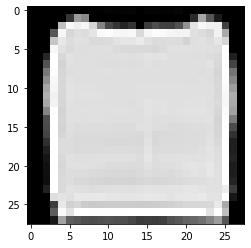

In [6]:
i = random.randint(0,60000)
plt.imshow( X_train[i] , cmap = 'gray')

In [7]:
label = y_train[i]
label

0

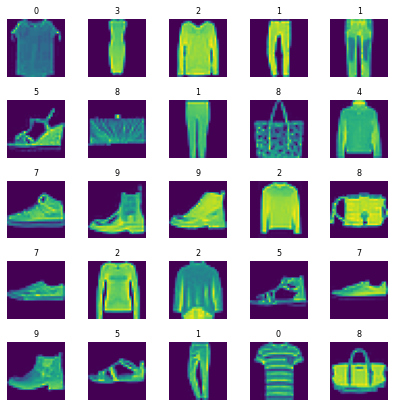

In [8]:
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (7,7))
axes = axes.ravel()
n_training = len(X_train)

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

# Etapa 4: Adição de ruído nas imagens

In [9]:
#normalização
X_train = X_train / 255
X_test = X_test / 255

In [10]:
#criando a img ruido
added_noise = np.random.randn(*(28,28))

In [11]:
added_noise.shape

(28, 28)

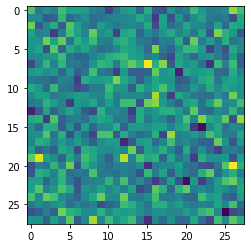

In [12]:
plt.imshow(added_noise);

In [13]:
noise_factor = 0.3
added_noise = noise_factor * np.random.randn(*(28,28))

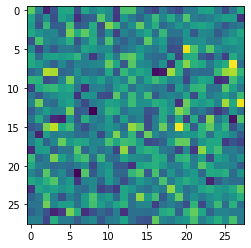

In [14]:
plt.imshow(added_noise);

In [15]:
noise_factor = 0.2
sample_image = X_train[10]
noisy_sample_image = sample_image + noise_factor * np.random.randn(*(28,28))

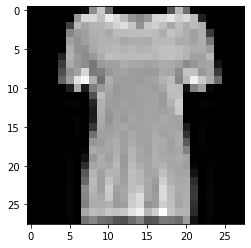

In [16]:
plt.imshow(sample_image, cmap='gray');

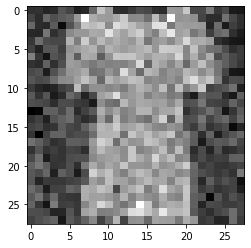

In [17]:
plt.imshow(noisy_sample_image, cmap='gray');

In [18]:
noisy_sample_image.max()

1.3797544636185786

In [19]:
noisy_sample_image.min()

-0.5070697529245826

In [20]:
#limitando
noisy_sample_image = np.clip(noisy_sample_image, 0., 1.)

In [21]:
noisy_sample_image.max()

1.0

In [22]:
noisy_sample_image.min()

0.0

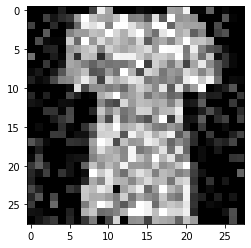

In [23]:
plt.imshow(noisy_sample_image, cmap='gray');

In [24]:
#cirando o X_train com ruido
X_train_noisy = []
noise_factor = 0.2

for sample_image in X_train:
  sample_image_noisy = sample_image + noise_factor * np.random.randn(*(28,28))
  sample_image_noisy = np.clip(sample_image_noisy, 0., 1.)
  X_train_noisy.append(sample_image_noisy)

In [25]:
type(X_train_noisy)

list

In [26]:
X_train_noisy = np.array(X_train_noisy)
type(X_train_noisy)

numpy.ndarray

In [27]:
X_train_noisy.shape

(60000, 28, 28)

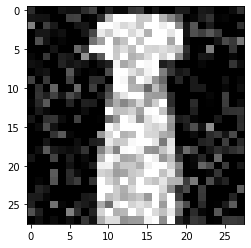

In [28]:
plt.imshow(X_train_noisy[50], cmap='gray');

In [29]:
X_test_noisy = []
noise_factor = 0.4

for sample_image in X_test:
  sample_image_noisy = sample_image + noise_factor * np.random.randn(*(28,28))
  sample_image_noisy = np.clip(sample_image_noisy, 0., 1.)
  X_test_noisy.append(sample_image_noisy)

In [30]:
X_test_noisy = np.array(X_test_noisy)
type(X_test_noisy)

numpy.ndarray

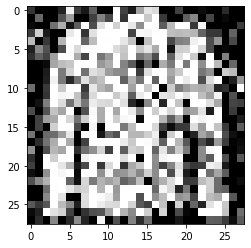

In [31]:
plt.imshow(X_test_noisy[50], cmap='gray');

# Etapa 5: Criação e treinamento do modelo

In [32]:
autoencoder = tf.keras.models.Sequential()

# Encoder
#16 feature detector 3x3 + maxpooling 
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same', input_shape=(28,28,1)))
autoencoder.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

#8 feature detector 3x3 + maxpooling 
autoencoder.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

# Encoded image, camada final da img codificada
#8 feature detector 3x3 
autoencoder.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding='same'))

#upsampling + convT aumentando a dimensão
autoencoder.add(tf.keras.layers.UpSampling2D((2,2)))
autoencoder.add(tf.keras.layers.Conv2DTranspose(8, (3,3), strides=1, padding='same'))

autoencoder.add(tf.keras.layers.UpSampling2D((2,2)))
autoencoder.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=1, padding='same', activation='sigmoid'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 8)        0

In [33]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
#treina img com ruido e a resposta é a img sem ruido
autoencoder.fit(X_train_noisy.reshape(-1, 28, 28, 1),
                X_train.reshape(-1, 28, 28, 1),
                epochs = 10,
                batch_size = 200)

Epoch 1/10
300/300 [==============================] - 4s 5ms/step - loss: 0.3560
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.3094
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.3043
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.3013
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2992
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2974
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2960
Epoch 8/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2949
Epoch 9/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2941
Epoch 10/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2933


# Etapa 6: Avaliação do modelo

In [35]:
denoised_images = autoencoder.predict(X_test_noisy[:15].reshape(-1,28,28,1))

In [36]:
denoised_images.shape

(15, 28, 28, 1)

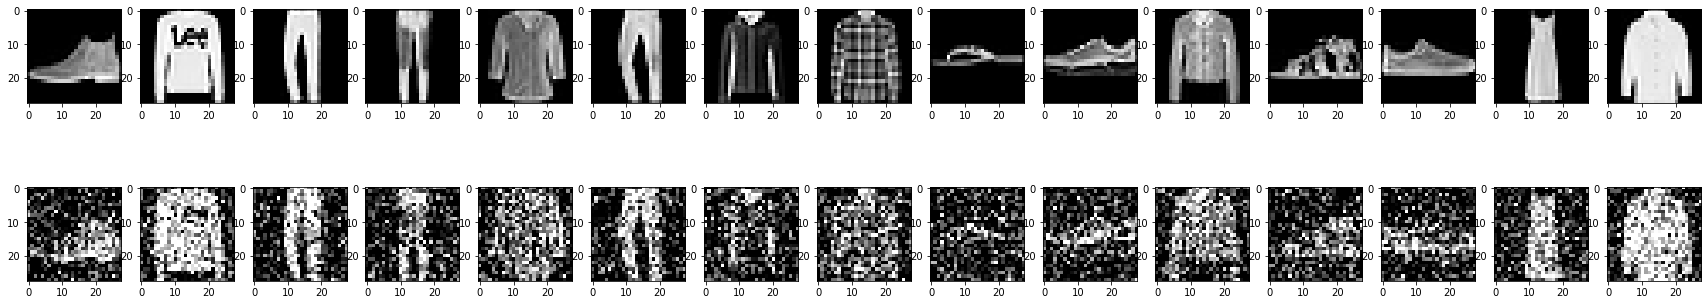

In [37]:
#imagem original vs filtrada
fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(30,6))
for images, row in zip([X_test[:15], X_test_noisy[:15]], axes):
  for img, ax in zip(images, row):
    ax.imshow(img.reshape((28,28)), cmap='gray')


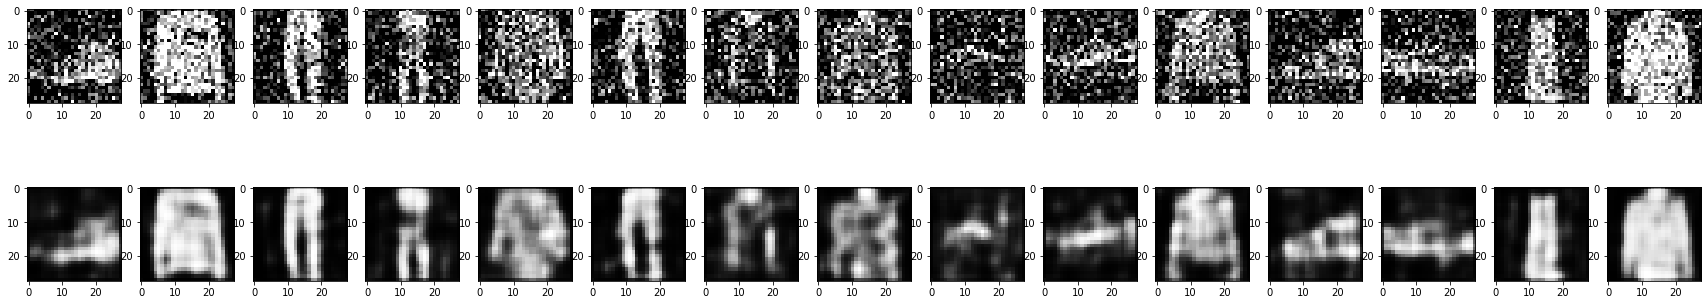

In [38]:
#img com ruido vs filtrada
fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(30,6))
for images, row in zip([X_test_noisy[:15], denoised_images], axes):
  for img, ax in zip(images, row):
    ax.imshow(img.reshape((28,28)), cmap='gray')

# Etapa 7: Confirmação das dimensões

In [39]:
# W = 28, F = 3, S = 1, Padding = same (P=F-1/2=1)
# o = (W-F+2*P/S) +1 = (28-3+2*1)/1 + 1 = 28
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="same", 
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [40]:
# W = 28, F = 3, S = 2, Padding = same (P=F-1/2=1)
# o = (W-F+2*P/S) +1 = (28-3+2*1)/2 + 1 = 14
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=2, padding="same", 
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Quando padding = valid, não são adicionadas "bordas" para preencher a imagem 
# W = 28, F = 3, S = 1, Padding = valid (P=0)
# o = (W-F+2*P/S) +1 = (28-3+0)/1 + 1 = 26
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="valid", 
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Quando padding = valid, não são adicionadas "bordas" para preencher a imagem
# W = 28, F = 3, S = 2, Padding = valid (P=0)
# o = (W-F+2*P/S) +1 = (28-3+0)/2 + 1 = 13
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=2, padding="valid", 
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 13, 13, 16)        160       
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
